In [1]:
import torch
import sys
sys.path.append("../")
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import plot_utils
from plot_utils import plot_comparison, plot_stats
from IPython.display import display, Markdown
import pandas as pd
import tempfile
from cumulant_analyzer import calculate_cumulants, to_numpy

from transformers.utils.logging import disable_progress_bar
disable_progress_bar()

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
ds = load_dataset("NeelNanda/pile-10k")['train']
filtered_indices = np.load('filtered_indices.npy')
test_indx = 686;
device = torch.device('cuda');
max_length = 256

In [3]:
test_indx = 686;
device = torch.device('cuda');
max_length = 256
test_sequence = ds['text'][filtered_indices[test_indx]]
steps = ["step4", "step16", "step64", "step256", "step1000", "step4000", "step16000", "step64000",  "step143000"]
# steps = ["step4"]
all_logits, all_probs = [], []
for step in steps:
    with tempfile.TemporaryDirectory() as temp_dir:
        model_name = "EleutherAI/pythia-160m-deduped"
        revision = step
        model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", revision = revision, local_files_only=False, cache_dir=temp_dir)  
        tokenizer = AutoTokenizer.from_pretrained(model_name, revision = revision, cache_dir=temp_dir, local_files_only=False)     
        input_ids = tokenizer.encode(test_sequence.strip(), add_special_tokens = False, \
                         return_tensors = "pt", max_length = max_length, truncation = True).to(device)
        outputs = model(input_ids, output_hidden_states=True)
        logits = outputs.logits.squeeze()
        probs = torch.nn.functional.softmax(logits, dim = -1)
        all_logits.append(logits)
        all_probs.append(probs)

The `GPTNeoXSdpaAttention` class is deprecated in favor of simply modifying the `config._attn_implementation`attribute of the `GPTNeoXAttention` class! It will be removed in v4.48


In [4]:
stats = calculate_cumulants(all_logits, all_probs)
stats = {key: to_numpy(tensor) for key, tensor in stats.items()}

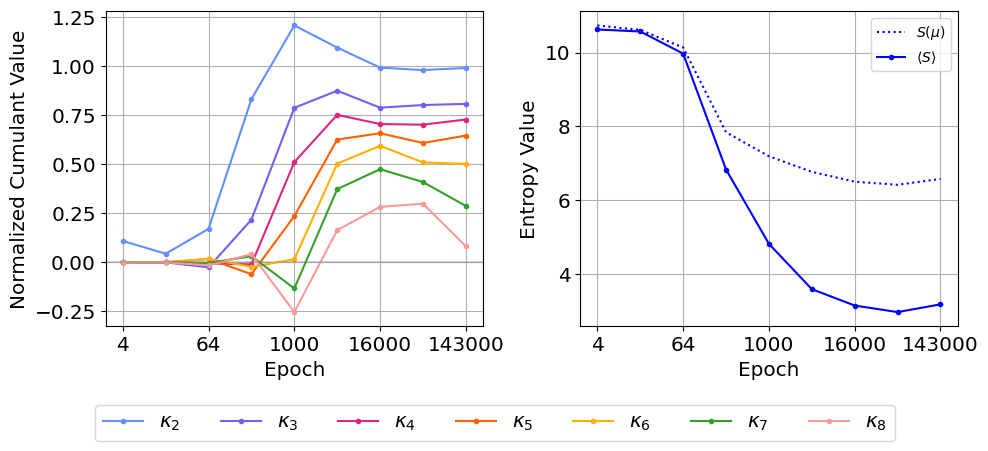

In [5]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))
plot_stats(stats, axes[0], title = None, xarr = np.arange(len(steps)), xlabel = "Epochs")
axes[0].set_ylabel("Normalized Cumulant Value", fontsize = "x-large")

ax = axes[1]
ax.plot(stats['entropy_com'], c = 'blue', linestyle = 'dotted',label = "$S(\mu)$")
ax.plot(stats['avg_entropy'], marker = '.', c = 'blue', label = "$\langle S \\rangle$")
ax.grid(True)
ax.set_xlabel('Epochs')
ax.legend()

ax.set_ylabel("Entropy Value", fontsize = "x-large")
for ax in axes:
    ax.set_xlabel("Epoch", fontsize = "x-large")
    ax.tick_params(which='both', labelsize="x-large")
    ax.set_xticks([idx for idx in range(0, 9, 2)], [int(step[4:]) for step in steps[::2]])

handles_psim, labels_psim = axes[0].get_legend_handles_labels()
fig.legend(handles_psim, labels_psim, loc='upper center', bbox_to_anchor=(0.5, -0.0), ncol = 7,  fontsize = "x-large")
plt.tight_layout()
plt.savefig(f'../plots/training.png', bbox_inches='tight')
plt.show()